# Recyclable Waste Classification

Creators: Kaan Kazancoglu, Hector He, Yu-Ting Hung

1.0 Import and Preprocess Data

*   [define our functions](#scrollTo=QQ-_NqKRkkox)
*   [convert image format](#scrollTo=HE44i6Oh4y_E)
*   [reshape images](#scrollTo=Uam1ZXf44HxC)
*   [split data](#scrollTo=YFsvCOxL8N_k)

2.0 Create a Baseline Model

*   [configure the model](#scrollTo=ko88fK1SLi4m)
*   [implement the model](#scrollTo=PqdU2HcoXwwA)
*   [evaluate the model](#scrollTo=9txwVHM8X5t9)

3.0 Upgrade the Model

*   [data augmentation + regularization/dropouts + additional layers/nodes](#scrollTo=InJ_06QwtgZ2)
*   [data augmentation + regularization/dropouts + residual connection](#scrollTo=H5cvki6Ktu9X)
*   [data augmentation + regularization/dropouts + batch normalization](#scrollTo=ootKB3P51sYi)

4.0 Use Pretrained Models

*   [load the pretrained model](#scrollTo=o8B2iJPFqKgT) 
*   [evaluate the pretrained model](#scrollTo=-wVcOMeUY_3r)
*   [customize the top layer](#scrollTo=zyWxL721l5Dt&line=1&uniqifier=1)
*   [fine tune the pretrained model](#scrollTo=ZtM4m7bVqvcZ)
*   [k-fold cross validation](#scrollTo=tO5wXmntPbc4)

5.0 Test Our Results

## **1.0 Data Import and Preprocessing**

**Connecting google drive**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

base_dir = "drive/My Drive/BA865-project/images_final"

Mounted at /content/drive


### Define some functions

1. image format conversion

download the "pyheif" package required for the format conversion

In [2]:
!pip install pillow pyheif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 13.0 MB/s eta 0:00:00


In [3]:
import os
from PIL import Image
import pyheif 

def convert_image_to_jpeg(input_path, output_path):
    filename, extension = os.path.splitext(input_path)
    
    if extension.lower() in ['.heic', '.heif']:
        heif_file = pyheif.read(input_path)
        image = Image.frombytes(
            heif_file.mode, 
            heif_file.size, 
            heif_file.data,
            "raw",
            heif_file.mode,
            heif_file.stride,
        )
    else:
        image = Image.open(input_path)

    image = image.convert('RGB') 
    image.save(output_path, 'JPEG', quality=95)


2. train/validation/test splitting

In [4]:
import numpy as np

def split_data(base_dir, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, seed=42):
    np.random.seed(seed)
    train_data, val_data, test_data = [], [], []
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        
        class_files = os.listdir(class_path)
        np.random.shuffle(class_files)
        
        train_end = int(train_ratio * len(class_files))
        val_end = train_end + int(val_ratio * len(class_files))

        train_data.extend([(os.path.join(class_path, f), class_name) for f in class_files[:train_end]])
        val_data.extend([(os.path.join(class_path, f), class_name) for f in class_files[train_end:val_end]])
        test_data.extend([(os.path.join(class_path, f), class_name) for f in class_files[val_end:]])

    return train_data, val_data, test_data

3. plot Loss and Accuracy over epoches for our models

In [5]:
import matplotlib.pyplot as plt

def drawLossAccuracy(model):
    loss = model.history["loss"]
    val_loss = model.history["val_loss"]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, "blue", label="Training loss")
    plt.plot(epochs, val_loss, "green", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.clf()
    accuracy = model.history["accuracy"]
    val_accuracy = model.history["val_accuracy"]
    plt.plot(epochs, accuracy, "blue", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "red", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

4. plot Loss and Accuracy over epoches in k-fold cross validation

In [6]:
def drawKFLossAccuacy(model, epochs):
    train_loss = model.history["loss"]
    val_loss = model.history["val_loss"]
    train_accuracy = model.history["accuracy"]
    val_accuracy = model.history["val_accuracy"]

    plt.plot(range(epochs), train_loss, "blue", label='Training Loss')
    plt.plot(range(epochs), val_loss,"green", label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(range(epochs), train_accuracy,  "blue", label='Training Accuracy')
    plt.plot(range(epochs), val_accuracy, "red",  label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

### Convert image formats

**Converting .HEIC to .JPEG**

Photos taken by cellphones are by default in the .HEIC format, and in order for Keras to process them, we have to convert them into .JPEG format first. We will do this by each category.

Our input images have four categories: glass, plastic, paper, and metal. Hence, we will convert the images of each category into .jpeg format one by one.

In [7]:
# define categories

categories = ['glass','plastic','paper','metal']

input_dir = "drive/My Drive/BA865-project/images_final/"
output_dir = "drive/My Drive/BA865-project/images_heic_to_jpeg/"

# file i/o
for category in categories:
    os.makedirs(output_dir+category+"_heic_to_jpeg/", exist_ok=True)
    for root, _, files in os.walk(input_dir+category+"_final"):
        for file in files:
            input_path = os.path.join(root, file)
            output_path = os.path.join(output_dir+category+"_heic_to_jpeg/", os.path.splitext(file)[0] + '.jpg')
            convert_image_to_jpeg(input_path, output_path)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Image reshaping

Since most of the pictures were taken by our iPhones and very large in size, we need to resize them properly for better use of our models.

In [8]:
from keras.preprocessing.image import ImageDataGenerator

base_dir = "drive/My Drive/BA865-project/images_heic_to_jpeg/"

datagen = ImageDataGenerator(rescale=1./255)

### Data splitting

Splitting dataset to train, test, and val

In [9]:
train_data, val_data, test_data = split_data(base_dir)

check the shape of our splitted datasets

In [ ]:
print(len(train_data),len(val_data),len(test_data))

72 24 26


**Prepare the images in train, test, and val for our models, we will use the outputs here to train our models**

In [10]:
import pandas as pd

train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame(train_data, columns=["filename", "class"]),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame(val_data, columns=["filename", "class"]),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame(test_data, columns=["filename", "class"]),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 72 validated image filenames belonging to 4 classes.
Found 24 validated image filenames belonging to 4 classes.
Found 26 validated image filenames belonging to 4 classes.


This step is to check whether the validation set has the same number of images of each category or not. If so, a random classifier (the worst model one can have) would yield an accuracy of 25%.

In [ ]:
pd.Series(val_generator.classes).value_counts()

0    6
1    6
3    6
2    6
dtype: int64

## **2.0 Create Baseline Model**

Our baseline model has no data augmentation procedures, and since there are only 4 label classes to predict, we intend to beat at least 25% of this model in terms of accuracy.

### Model Configuration

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input

# @tf.function might add this to speed it up
def create_model():
    inputs = Input(shape=(224, 224, 3))

    x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2) (x)
    x = Conv2D(256, kernel_size=3, activation="relu", padding ="same")(x)
    x = Flatten()(x)
    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
baseline_model = create_model()

Adding a callbacks term

In [ ]:
from keras import callbacks

callbacks_list = [ # do not add a callback for now
    callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
    ),
      callbacks.ModelCheckpoint(
      filepath="baseline.keras",
    monitor="val_loss",
    save_best_only=True
)]

### Model Implementation

Record the performance of the baseline model on each epoch.

In [ ]:
history = baseline_model.fit(train_generator, validation_data = val_generator, epochs = 30, batch_size = 32)

Epoch 1/30
3/3 [==============================] - 40s 18s/step - loss: 3.4833 - accuracy: 0.2222 - val_loss: 1.4258 - val_accuracy: 0.2917
Epoch 2/30
3/3 [==============================] - 38s 12s/step - loss: 1.4319 - accuracy: 0.3056 - val_loss: 1.4183 - val_accuracy: 0.2500
Epoch 3/30
3/3 [==============================] - 36s 12s/step - loss: 1.3772 - accuracy: 0.3194 - val_loss: 1.3777 - val_accuracy: 0.2500
Epoch 4/30
3/3 [==============================] - 31s 13s/step - loss: 1.3690 - accuracy: 0.2778 - val_loss: 1.3515 - val_accuracy: 0.4583
Epoch 5/30
3/3 [==============================] - 31s 9s/step - loss: 1.3289 - accuracy: 0.4167 - val_loss: 1.3260 - val_accuracy: 0.2917
Epoch 6/30
3/3 [==============================] - 35s 11s/step - loss: 1.4129 - accuracy: 0.3333 - val_loss: 1.3058 - val_accuracy: 0.2500
Epoch 7/30
3/3 [==============================] - 36s 11s/step - loss: 1.3049 - accuracy: 0.2917 - val_loss: 1.3608 - val_accuracy: 0.2917
Epoch 8/30
3/3 [============

**our baseline model reaches an accuracy of 50% on the validation set, which is quite impressive, compared with the 25% accuracy of a blind model**

### Model Evaluation

display the shape of the baseline model

In [ ]:
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856 

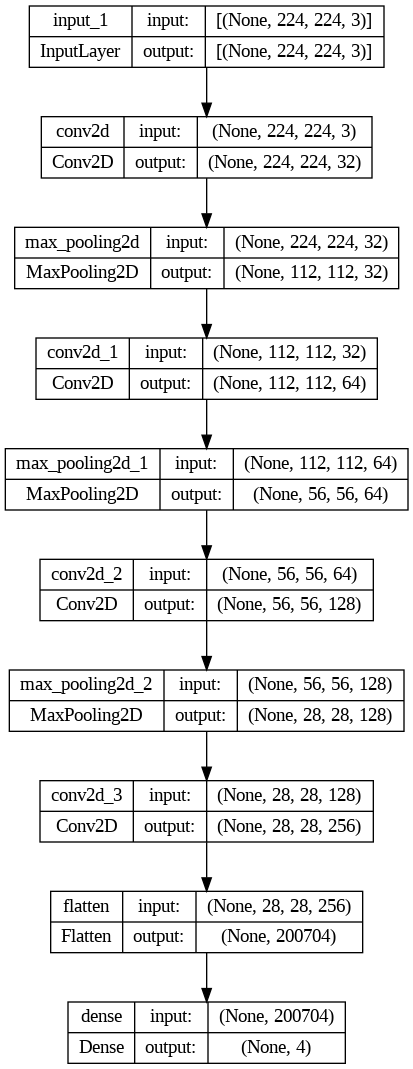

In [ ]:
keras.utils.plot_model(baseline_model, show_shapes = True)

take a look at the predicted probabilities of each category for every image in our validation set, and the predicted categories. (0: plastic, 1: paper, 2: metal, 3: glass)

In [ ]:
predictions = baseline_model.predict(val_generator)
print(predictions)

1/1 [==============================] - 6s 6s/step
[[9.38054148e-12 9.99999940e-01 9.60592748e-19 1.69169098e-14]
 [6.74340129e-01 2.68373149e-03 5.47478558e-05 3.22921246e-01]
 [2.85316096e-03 9.93862927e-01 2.84826197e-03 4.35642374e-04]
 [6.66804850e-01 4.33230400e-03 1.11008136e-04 3.28751743e-01]
 [1.00986227e-01 3.63178580e-04 1.62471442e-05 8.98634374e-01]
 [1.73407138e-08 8.21906328e-03 9.91780877e-01 3.61698369e-08]
 [1.37503482e-02 4.06934619e-01 4.11931366e-01 1.67383686e-01]
 [7.40412121e-10 3.93659372e-09 9.99798775e-01 2.01168674e-04]
 [4.97506499e-01 5.49740233e-02 1.76628039e-03 4.45753068e-01]
 [7.69958675e-01 6.88221827e-02 3.82915459e-05 1.61180854e-01]
 [4.35824581e-13 9.99999821e-01 1.26052075e-08 6.95282125e-08]
 [1.67068198e-01 4.36481476e-01 9.80942771e-02 2.98356146e-01]
 [8.85634217e-03 9.73448753e-01 1.50555950e-02 2.63926270e-03]
 [2.19037324e-01 9.69746262e-02 1.64659340e-02 6.67522073e-01]
 [6.38669881e-05 1.45382024e-02 1.64539903e-01 8.20858002e-01]
 [3.2

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

[1 0 1 0 3 2 2 2 0 0 1 1 1 3 3 1 1 2 2 1 2 0 0 0]


plot the performance of our baseline model

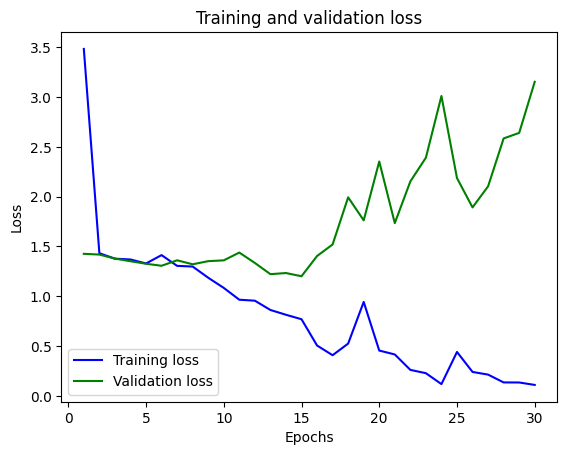

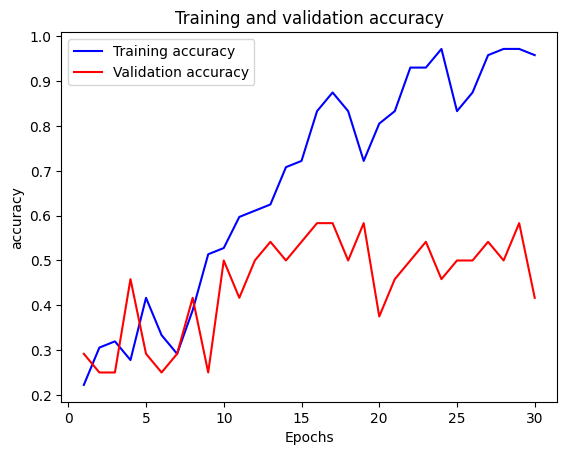

In [ ]:
drawLossAccuracy(history)

What are the problems?

1. the model starts overfitting very soon, right after ~ epoch 10

2. the best validation accuracy achieved is only around 0.5, far from desired 

3. there are way too many parameters

## **3.0 Model Upgrades** 

### 3.1 Data Augmentation + Regularization/Dropouts + Additional Nodes/Layers

- first we used data augmentation to avoid overfitting due to a small training set
- we employed both L2 regularization at each Conv2D layer along with a dropout term at the end of the baseline model right before the dense layer
- we added another MaxPooling2D layer and another Conv2D layer at the end of the baseline model

#### tweaking

Define a Data Augmentation Layer which will be used for all following models

In [ ]:
data_augmentation = keras.Sequential(
            [keras.layers.RandomFlip("horizontal"),
             keras.layers.RandomFlip("vertical"),
             keras.layers.RandomRotation(0.5),
             keras.layers.RandomZoom(0.2)])

In [ ]:
from keras import regularizers

# @tf.function # add this to speed it up

def upgrade_model_1():
    inputs = Input(shape=(224, 224, 3))

    x = data_augmentation(inputs) # adding a data augmentation step
    x = Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.002))(inputs)
    x = MaxPooling2D(pool_size=2)(x) # adding a regularizer for each kernel in the Conv2D layer
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.002))(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.002))(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(256, kernel_size=3, activation="relu", padding ="same", kernel_regularizer=regularizers.l2(0.002))(x)
    x = MaxPooling2D(pool_size=2)(x) # adding a new layer
    x = Conv2D(256, kernel_size=3,activation="relu", padding = 'same', kernel_regularizer=regularizers.l2(0.002))(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x) # adding a dropout layer right before the classifier
    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
upgraded_model_1 = upgrade_model_1()

In [ ]:
history_upgraded_1 = upgraded_model_1.fit(train_generator, validation_data=val_generator, epochs=40, batch_size=32)

Epoch 1/40
3/3 [==============================] - 43s 14s/step - loss: 2.6482 - accuracy: 0.2083 - val_loss: 2.3689 - val_accuracy: 0.2500
Epoch 2/40
3/3 [==============================] - 32s 9s/step - loss: 2.3573 - accuracy: 0.2917 - val_loss: 2.2611 - val_accuracy: 0.2500
Epoch 3/40
3/3 [==============================] - 37s 11s/step - loss: 2.2444 - accuracy: 0.2222 - val_loss: 2.1612 - val_accuracy: 0.2500
Epoch 4/40
3/3 [==============================] - 38s 11s/step - loss: 2.1395 - accuracy: 0.3194 - val_loss: 2.0705 - val_accuracy: 0.3333
Epoch 5/40
3/3 [==============================] - 35s 16s/step - loss: 2.0327 - accuracy: 0.3194 - val_loss: 1.9922 - val_accuracy: 0.2917
Epoch 6/40
3/3 [==============================] - 31s 14s/step - loss: 1.9594 - accuracy: 0.2639 - val_loss: 1.9230 - val_accuracy: 0.2500
Epoch 7/40
3/3 [==============================] - 33s 9s/step - loss: 1.8927 - accuracy: 0.2500 - val_loss: 1.8584 - val_accuracy: 0.3333
Epoch 8/40
3/3 [=============

#### evaluation

In [ ]:
upgraded_model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 128)       7385

plot the performance of the newly upgraded model

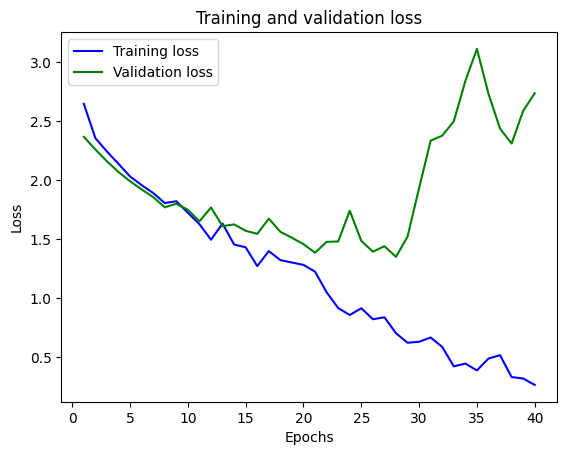

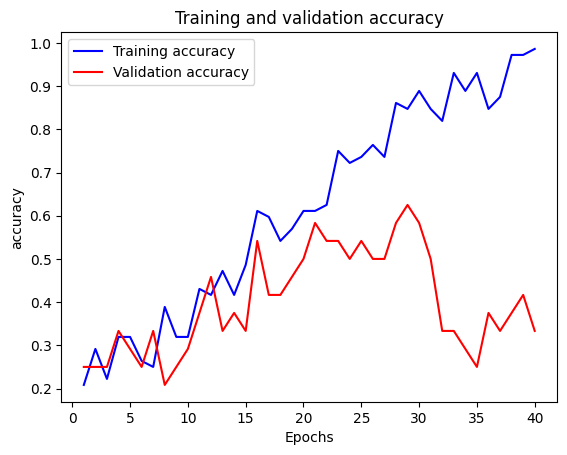

In [ ]:
drawLossAccuracy(history_upgraded_1)

Anything?

1. overfitting is slower but still happens after around epoch 17

2. less parameters after the dropout layer and regularizers, but accuracy is not improving, possibly due to the small size of the training set.

### 3.2 Data Augmentation + Residual Connection + Regularization/Dropouts

- for the obvious reason we kept the data augmentation as well as the regularization/dropout terms
- we applied residual connection here since our model has become too deep

#### tweaking

In [ ]:
from keras.layers import add

# @tf.function # add this to speed it up

def upgrade_model_2():
    inputs = Input(shape=(224, 224, 3))

    x = data_augmentation(inputs) # adding a data augmentation step
    x = Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.002))(inputs)
    residual = x
    x = MaxPooling2D(pool_size=2, padding = 'same')(x)
    residual = Conv2D(32, kernel_size = 1, strides = 2)(residual)
    x = add([x, residual])
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.002))(x)
    x = MaxPooling2D(pool_size=2, padding = 'same')(x)
    residual = Conv2D(64, kernel_size = 1, strides = 2)(residual)
    x = add([x, residual])
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.002))(x)
    x = MaxPooling2D(pool_size=2, padding = 'same')(x)
    residual = Conv2D(128, kernel_size = 1, strides = 2)(residual)
    x = add([x, residual])
    x = Conv2D(256, kernel_size=3, activation="relu", padding ="same", kernel_regularizer=regularizers.l2(0.002))(x)
    residual = Conv2D(256, kernel_size = 1)(residual)
    x = add([x, residual])
    x = Flatten()(x)
    x = Dropout(0.5)(x) # adding a dropout layer right before the classifier
    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
upgraded_model_2 = upgrade_model_2()

In [ ]:
history_upgraded_2 = upgraded_model_2.fit(train_generator, validation_data=val_generator, epochs=40, batch_size=32)

Epoch 1/40
3/3 [==============================] - 40s 12s/step - loss: 3.7612 - accuracy: 0.2361 - val_loss: 4.5650 - val_accuracy: 0.2500
Epoch 2/40
3/3 [==============================] - 33s 15s/step - loss: 2.5381 - accuracy: 0.2361 - val_loss: 2.1419 - val_accuracy: 0.2917
Epoch 3/40
3/3 [==============================] - 37s 11s/step - loss: 2.9719 - accuracy: 0.4306 - val_loss: 2.6150 - val_accuracy: 0.4583
Epoch 4/40
3/3 [==============================] - 38s 12s/step - loss: 1.9413 - accuracy: 0.5000 - val_loss: 2.0746 - val_accuracy: 0.2917
Epoch 5/40
3/3 [==============================] - 33s 10s/step - loss: 1.7371 - accuracy: 0.5278 - val_loss: 2.0250 - val_accuracy: 0.5833
Epoch 6/40
3/3 [==============================] - 35s 16s/step - loss: 1.5134 - accuracy: 0.6250 - val_loss: 1.7903 - val_accuracy: 0.5833
Epoch 7/40
3/3 [==============================] - 41s 11s/step - loss: 1.3927 - accuracy: 0.6944 - val_loss: 1.7538 - val_accuracy: 0.4583
Epoch 8/40
3/3 [===========

#### evaluation

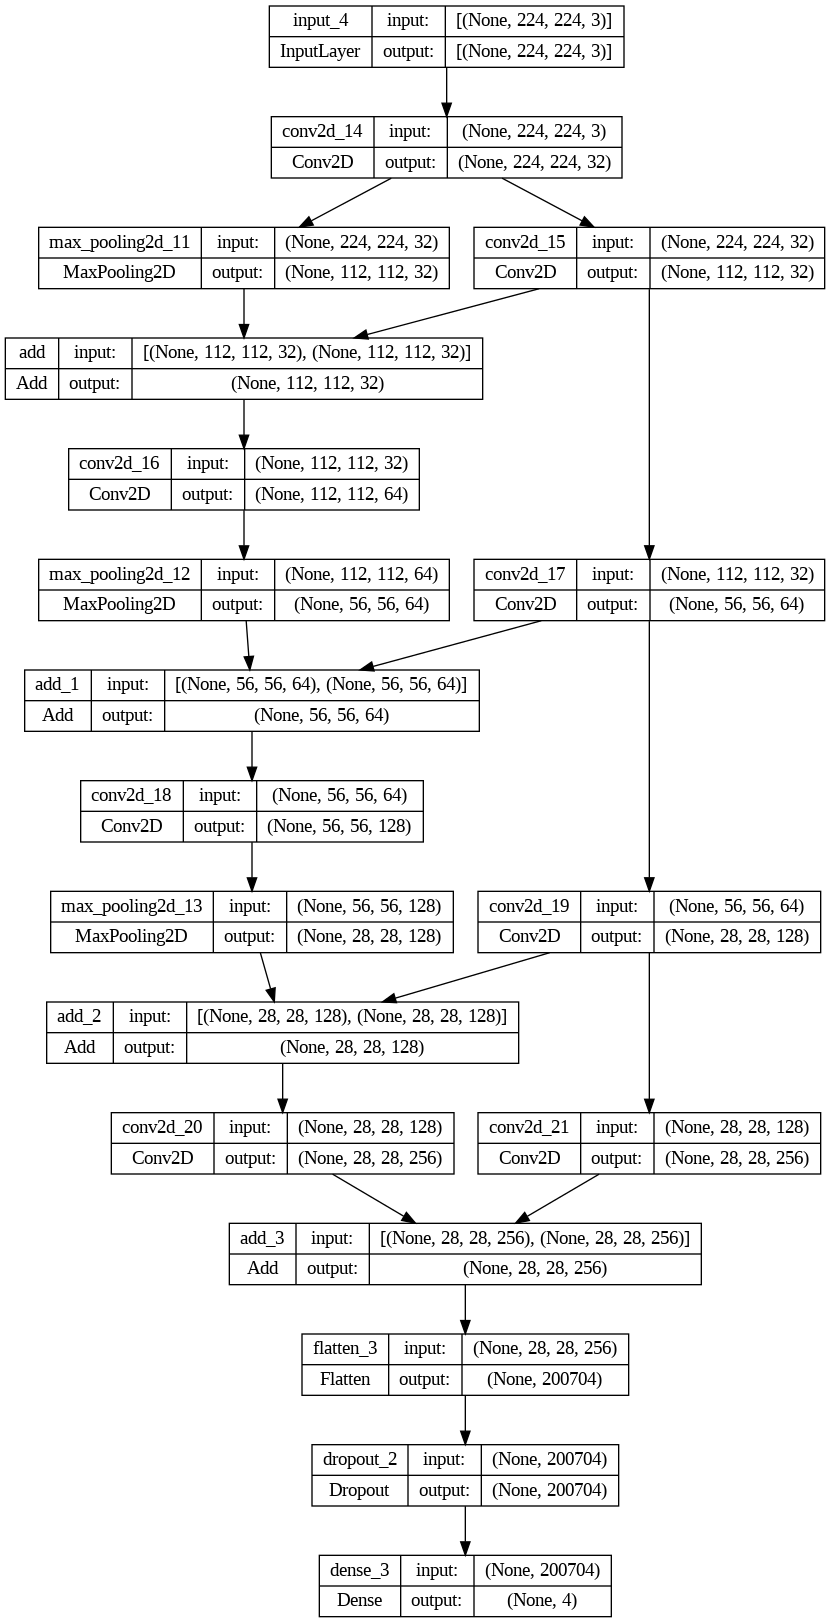

In [ ]:
keras.utils.plot_model(upgraded_model_2, show_shapes = True)

In [ ]:
upgraded_model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 224, 224, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_11 (MaxPooling2D  (None, 112, 112, 32  0          ['conv2d_14[0][0]']              
 )                              )                                                           

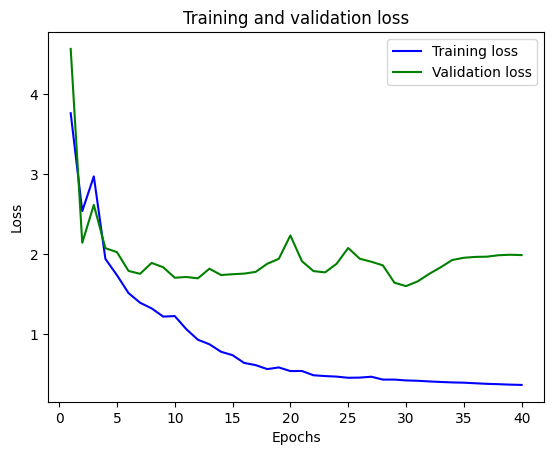

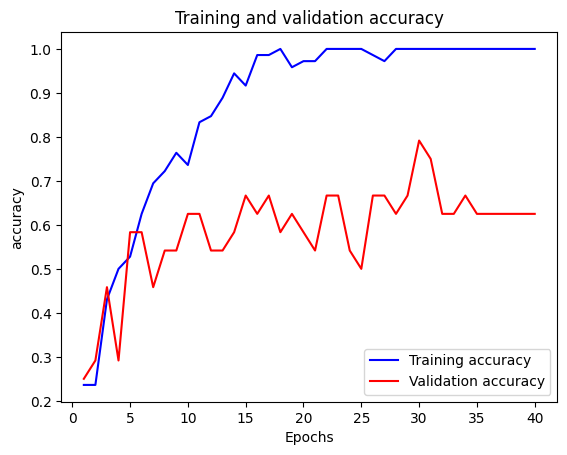

In [ ]:
drawLossAccuracy(history_upgraded_2)

### 3.3 Data Augmentation + Batch Normalization + Regularization/Dropout

- in addition to what we have done in the previous two 

#### tweaking

In [ ]:
from keras.layers import BatchNormalization, Activation

def upgrade_model_3():
    inputs = Input(shape=(224, 224, 3))

    x = data_augmentation(inputs) # adding a data augmentation step
    x = Conv2D(32, kernel_size=3, use_bias=False, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(64, kernel_size=3, use_bias=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(128, kernel_size=3, use_bias=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(256, kernel_size=3, use_bias=False, padding ="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x) # adding a dropout layer right before the classifier
    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
upgraded_model_3 = upgrade_model_3()

In [ ]:
history_upgraded_3 = upgraded_model_3.fit(train_generator, validation_data=val_generator, epochs=30, batch_size=32)

Epoch 1/30
3/3 [==============================] - 57s 16s/step - loss: 5.7309 - accuracy: 0.3056 - val_loss: 3.2618 - val_accuracy: 0.2500
Epoch 2/30
3/3 [==============================] - 35s 16s/step - loss: 12.1678 - accuracy: 0.4861 - val_loss: 4.4684 - val_accuracy: 0.2500
Epoch 3/30
3/3 [==============================] - 42s 19s/step - loss: 12.2030 - accuracy: 0.5417 - val_loss: 1.9540 - val_accuracy: 0.3750
Epoch 4/30
3/3 [==============================] - 39s 12s/step - loss: 7.4195 - accuracy: 0.6944 - val_loss: 1.8011 - val_accuracy: 0.2917
Epoch 5/30
3/3 [==============================] - 38s 16s/step - loss: 1.8540 - accuracy: 0.8194 - val_loss: 1.7041 - val_accuracy: 0.3750
Epoch 6/30
3/3 [==============================] - 33s 8s/step - loss: 2.2154 - accuracy: 0.7917 - val_loss: 1.7326 - val_accuracy: 0.2500
Epoch 7/30
3/3 [==============================] - 33s 15s/step - loss: 0.3190 - accuracy: 0.9444 - val_loss: 2.0854 - val_accuracy: 0.2917
Epoch 8/30
3/3 [==========

#### evaluation

In [ ]:
upgraded_model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      864       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18432 

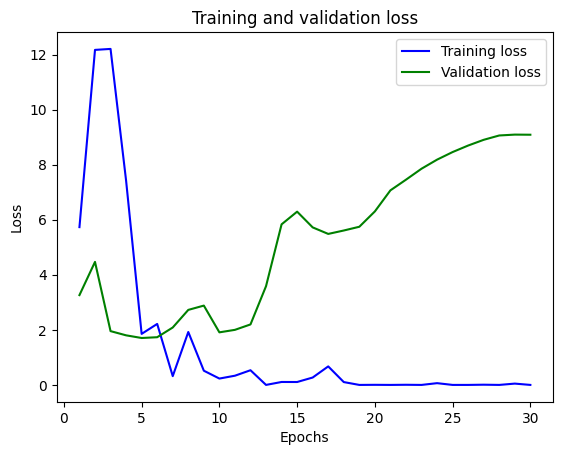

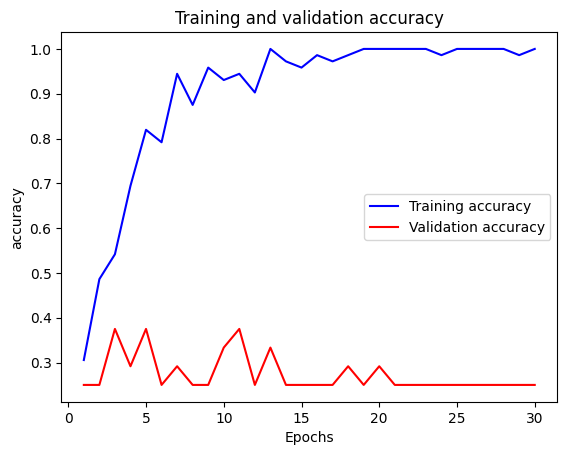

In [ ]:
drawLossAccuracy(history_upgraded_3)

## **4.0 Use Pretrained Models**

### load the pretrained model

we chose to use the pre-trained VGG16 model in Keras

In [12]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top = False,
    input_shape = (224, 224, 3))

for layer in conv_base.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


regenerate the train/val/test data for the pretrained model

In [13]:
train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame(train_data, columns=["filename", "class"]),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame(val_data, columns=["filename", "class"]),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame(test_data, columns=["filename", "class"]),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 72 validated image filenames belonging to 4 classes.
Found 24 validated image filenames belonging to 4 classes.
Found 26 validated image filenames belonging to 4 classes.


In [ ]:
x =  Flatten()(conv_base.output)

prediction = Dense(4, activation='softmax')(x)

pretrained_model = Model(inputs = conv_base.input, outputs = prediction)

pretrained_model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
        )

In [ ]:
pretrained_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
pretrained_history = pretrained_model.fit(train_generator, validation_data = val_generator, epochs = 30)

Epoch 1/30
3/3 [==============================] - 89s 28s/step - loss: 2.0153 - accuracy: 0.2917 - val_loss: 1.0005 - val_accuracy: 0.5833
Epoch 2/30
3/3 [==============================] - 80s 35s/step - loss: 1.0094 - accuracy: 0.5972 - val_loss: 1.1425 - val_accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 78s 26s/step - loss: 0.6171 - accuracy: 0.8056 - val_loss: 1.1849 - val_accuracy: 0.5000
Epoch 4/30
3/3 [==============================] - 78s 35s/step - loss: 0.2936 - accuracy: 0.9028 - val_loss: 0.9898 - val_accuracy: 0.6250
Epoch 5/30
3/3 [==============================] - 78s 34s/step - loss: 0.2613 - accuracy: 0.9167 - val_loss: 1.0065 - val_accuracy: 0.5833
Epoch 6/30
3/3 [==============================] - 78s 23s/step - loss: 0.1766 - accuracy: 0.9444 - val_loss: 0.6895 - val_accuracy: 0.6667
Epoch 7/30
3/3 [==============================] - 77s 23s/step - loss: 0.0847 - accuracy: 0.9722 - val_loss: 0.6548 - val_accuracy: 0.7083
Epoch 8/30
3/3 [===========

### evaluation

plot the accuracy and loss over validation set

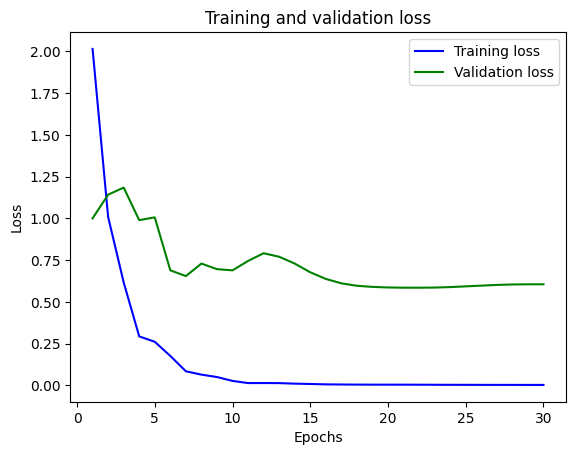

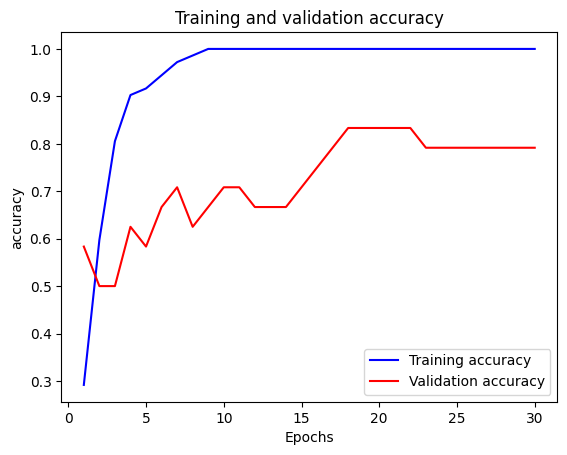

In [ ]:
drawLossAccuracy(pretrained_history)

### Customize the top layer of pretrained model

We increase the epochs to 40 and add GlobalAveragePooling layer to deal with our small dataset.

In [ ]:
pretrained_model = keras.applications.vgg16.VGG16(weights="imagenet", include_top = False, input_shape = (224, 224, 3))
pretrained_model.trainable = False

customized_model = tf.keras.Sequential()
customized_model.add(pretrained_model)
customized_model.add(tf.keras.layers.GlobalAveragePooling2D())
customized_model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [ ]:
customized_model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy'])

In [ ]:
customized_model_history = customized_model.fit(train_generator, validation_data = val_generator, epochs = 40)

Epoch 1/40
3/3 [==============================] - 83s 37s/step - loss: 1.6064 - accuracy: 0.2500 - val_loss: 1.5695 - val_accuracy: 0.2917
Epoch 2/40
3/3 [==============================] - 77s 34s/step - loss: 1.5127 - accuracy: 0.2500 - val_loss: 1.4839 - val_accuracy: 0.2500
Epoch 3/40
3/3 [==============================] - 77s 23s/step - loss: 1.4507 - accuracy: 0.2639 - val_loss: 1.4205 - val_accuracy: 0.2917
Epoch 4/40
3/3 [==============================] - 76s 35s/step - loss: 1.3792 - accuracy: 0.2917 - val_loss: 1.3814 - val_accuracy: 0.2917
Epoch 5/40
3/3 [==============================] - 77s 34s/step - loss: 1.3507 - accuracy: 0.2917 - val_loss: 1.3600 - val_accuracy: 0.2917
Epoch 6/40
3/3 [==============================] - 78s 35s/step - loss: 1.3364 - accuracy: 0.3611 - val_loss: 1.3472 - val_accuracy: 0.3333
Epoch 7/40
3/3 [==============================] - 78s 23s/step - loss: 1.3227 - accuracy: 0.3889 - val_loss: 1.3390 - val_accuracy: 0.3333
Epoch 8/40
3/3 [===========

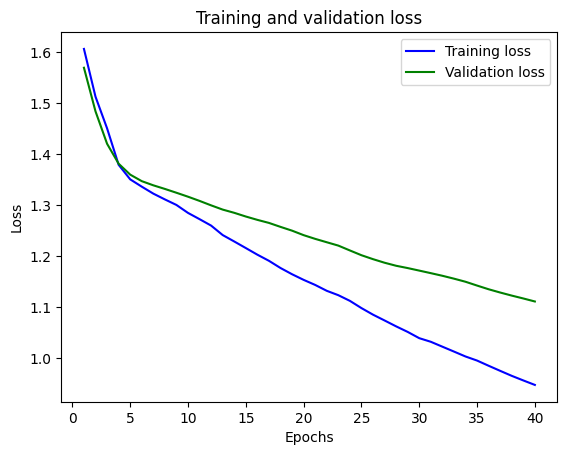

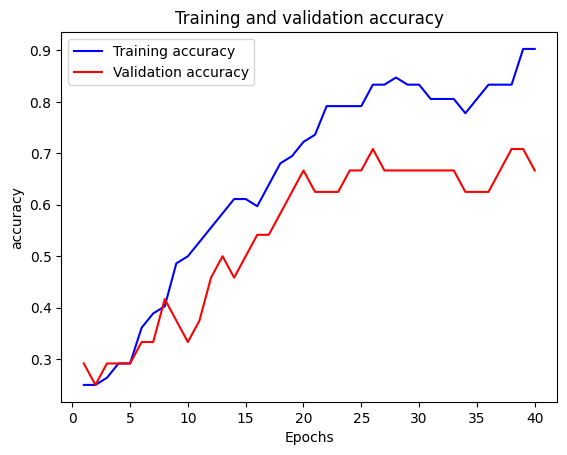

In [ ]:
drawLossAccuracy(customized_model_history)

### Tuning the pretrained model
We implement data augmentation and keep the epochs as 40 as well as the GAP layer.

In [ ]:
input_shape = (224, 224, 3)
inputs = tf.keras.layers.Input(shape=input_shape)
pretrained_model = keras.applications.vgg16.VGG16(weights="imagenet", include_top = False, input_tensor=data_augmentation(inputs))
pretrained_model.trainable = False

# Customize the top layer
cuAu_model = tf.keras.Sequential()
cuAu_model.add(pretrained_model)
cuAu_model.add(tf.keras.layers.GlobalAveragePooling2D())
cuAu_model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [ ]:
cuAu_model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
        )

customized_model_history = cuAu_model.fit(train_generator, validation_data = val_generator, epochs = 40)

Epoch 1/40
3/3 [==============================] - 107s 39s/step - loss: 1.7136 - accuracy: 0.2500 - val_loss: 1.6525 - val_accuracy: 0.2500
Epoch 2/40
3/3 [==============================] - 78s 35s/step - loss: 1.6108 - accuracy: 0.2361 - val_loss: 1.5741 - val_accuracy: 0.2500
Epoch 3/40
3/3 [==============================] - 78s 36s/step - loss: 1.5499 - accuracy: 0.2500 - val_loss: 1.5082 - val_accuracy: 0.2500
Epoch 4/40
3/3 [==============================] - 79s 26s/step - loss: 1.4866 - accuracy: 0.2083 - val_loss: 1.4472 - val_accuracy: 0.2083
Epoch 5/40
3/3 [==============================] - 79s 26s/step - loss: 1.4381 - accuracy: 0.2361 - val_loss: 1.3955 - val_accuracy: 0.2083
Epoch 6/40
3/3 [==============================] - 77s 25s/step - loss: 1.3783 - accuracy: 0.2778 - val_loss: 1.3578 - val_accuracy: 0.1667
Epoch 7/40
3/3 [==============================] - 78s 26s/step - loss: 1.3776 - accuracy: 0.2639 - val_loss: 1.3352 - val_accuracy: 0.3333
Epoch 8/40
3/3 [==========

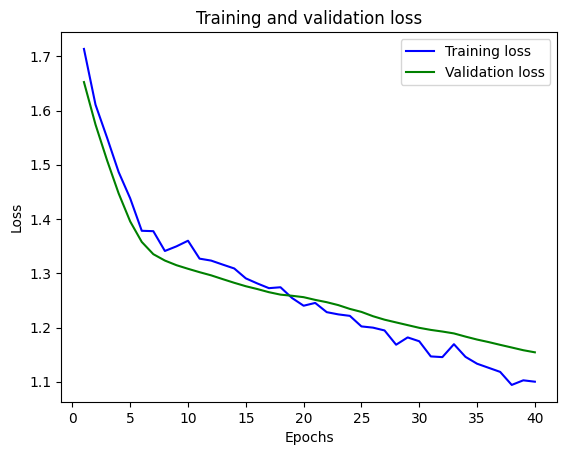

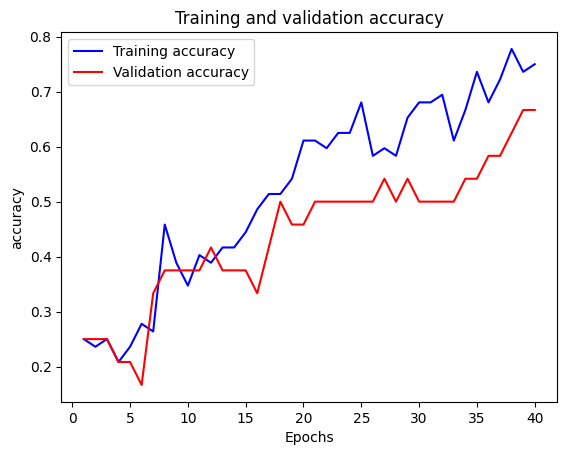

In [ ]:
drawLossAccuracy(customized_model_history)

### K fold pretrained model

Rather than data augmentation, we also tried K-fold validation. We set K=4, since we have 4 classes, and also set the epochs to 30.

In [ ]:
# define pre-trained model

def pretrained_model():
    inputs = Input(shape=(224, 224, 3))
    pretrained_model = keras.applications.vgg16.VGG16(weights="imagenet", include_top = False, input_shape = (224, 224, 3))

    # Freeze the weights of the pre-trained layers
    pretrained_model.trainable = False

    x =  Flatten()(pretrained_model.output)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs=pretrained_model.inputs, outputs=outputs)
    model.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

all_data = train_data + val_data

image_filepaths = [path for path, _ in all_data]
class_labels = [label for _, label in all_data]

n_splits = 4
kfold = StratifiedKFold(n_splits=n_splits, shuffle=False)

X = np.array([item[0] for item in all_data])
y = np.array([item[1] for item in all_data])

epochs = 30
train_loss = [0] * epochs
val_loss = [0] * epochs
train_accuracy = [0] * epochs
val_accuracy = [0] * epochs

for train_index, val_index in kfold.split(X, y):
    train_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame([all_data[i] for i in train_index], columns=["filename", "class"]),
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical"
    )

    val_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame([all_data[i] for i in val_index], columns=["filename", "class"]),
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical"
    )

    model = pretrained_model()
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

  
    for epoch in range(epochs):
        train_loss[epoch] += history.history['loss'][epoch] / n_splits
        val_loss[epoch] += history.history['val_loss'][epoch] / n_splits
        train_accuracy[epoch] += history.history['accuracy'][epoch] / n_splits
        val_accuracy[epoch] += history.history['val_accuracy'][epoch] / n_splits

Found 72 validated image filenames belonging to 4 classes.
Found 24 validated image filenames belonging to 4 classes.
Epoch 1/30
3/3 [==============================] - 54s 17s/step - loss: 2.2605 - accuracy: 0.2917 - val_loss: 1.4132 - val_accuracy: 0.2917
Epoch 2/30
3/3 [==============================] - 49s 22s/step - loss: 1.1952 - accuracy: 0.5278 - val_loss: 1.4398 - val_accuracy: 0.4583
Epoch 3/30
3/3 [==============================] - 56s 19s/step - loss: 0.4675 - accuracy: 0.8472 - val_loss: 1.6413 - val_accuracy: 0.4167
Epoch 4/30
3/3 [==============================] - 58s 26s/step - loss: 0.4064 - accuracy: 0.8472 - val_loss: 1.2288 - val_accuracy: 0.5000
Epoch 5/30
3/3 [==============================] - 57s 19s/step - loss: 0.1604 - accuracy: 0.9861 - val_loss: 1.1661 - val_accuracy: 0.5417
Epoch 6/30
3/3 [==============================] - 50s 17s/step - loss: 0.1053 - accuracy: 0.9861 - val_loss: 1.3782 - val_accuracy: 0.5417
Epoch 7/30
3/3 [==============================] 

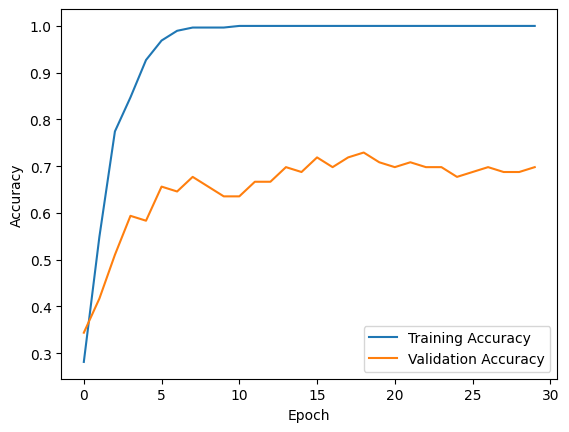

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(range(epochs), train_accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

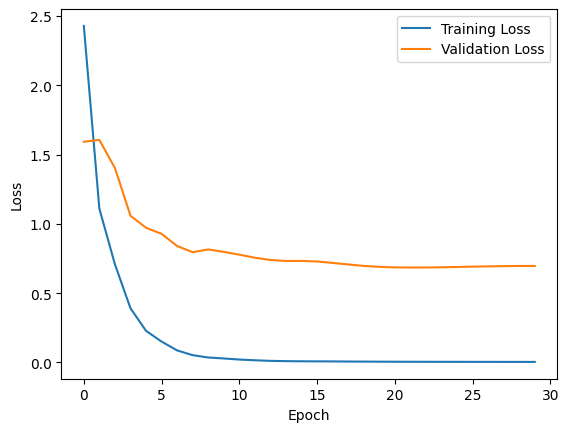

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(range(epochs), train_loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


### K fold pretrained model v2.8

After many trial and error, different combination of number of epochs (10, 12, 15, 20, 30, 40), we found out the better performing number of epochs is between 12 and 20. We applied low learning rate to slow down the overfitting in the very beginning of epochs. Shuffling our dataset better helps the model to learn. "When the dataset is small, shuffling can help ensure that each fold is representative of the full dataset and that the model is not overly biased towards a specific subset of the data." -- Chatgpt.

1. Low learning rate
2. Epoches = 15
3. Shuffle = True

In [14]:
# define pre-trained model
from tensorflow.keras.optimizers import Adam

def low_learing_pretrained_model():
    inputs = Input(shape=(224, 224, 3))
    pretrained_model = keras.applications.vgg16.VGG16(weights="imagenet",
                                                      include_top = False, input_shape = (224, 224, 3))

    # Freeze the weights of the pre-trained layers
    pretrained_model.trainable = False

    x =  Flatten()(pretrained_model.output)
    outputs = Dense(4, activation='softmax')(x)
    # Compile the model with an appropriate optimizer and learning rate
    adam = Adam(lr=0.001)
    model = Model(inputs=pretrained_model.inputs, outputs=outputs)
    model.compile( loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [16]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

all_data = train_data + val_data

image_filepaths = [path for path, _ in all_data]
class_labels = [label for _, label in all_data]

n_splits = 4
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

X = np.array([item[0] for item in all_data])
y = np.array([item[1] for item in all_data])

epochs = 15
train_loss = [0] * epochs
val_loss = [0] * epochs
train_accuracy = [0] * epochs
val_accuracy = [0] * epochs

for train_index, val_index in kfold.split(X, y):
    train_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame([all_data[i] for i in train_index], columns=["filename", "class"]),
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical"
    )

    val_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame([all_data[i] for i in val_index], columns=["filename", "class"]),
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical"
    )

    low_learning_model = low_learing_pretrained_model()
    history = low_learning_model.fit(train_generator, validation_data=val_generator, epochs=epochs)

  
    for epoch in range(epochs):
        train_loss[epoch] += history.history['loss'][epoch] / n_splits
        val_loss[epoch] += history.history['val_loss'][epoch] / n_splits
        train_accuracy[epoch] += history.history['accuracy'][epoch] / n_splits
        val_accuracy[epoch] += history.history['val_accuracy'][epoch] / n_splits


Found 72 validated image filenames belonging to 4 classes.
Found 24 validated image filenames belonging to 4 classes.


Epoch 1/15
3/3 [==============================] - 86s 36s/step - loss: 2.4332 - accuracy: 0.2500 - val_loss: 1.7851 - val_accuracy: 0.2917
Epoch 2/15
3/3 [==============================] - 87s 23s/step - loss: 1.4165 - accuracy: 0.4306 - val_loss: 1.3928 - val_accuracy: 0.3750
Epoch 3/15
3/3 [==============================] - 70s 31s/step - loss: 0.5547 - accuracy: 0.7917 - val_loss: 0.9836 - val_accuracy: 0.6250
Epoch 4/15
3/3 [==============================] - 74s 32s/step - loss: 0.3744 - accuracy: 0.9167 - val_loss: 1.1339 - val_accuracy: 0.5417
Epoch 5/15
3/3 [==============================] - 72s 21s/step - loss: 0.2785 - accuracy: 0.9583 - val_loss: 0.8505 - val_accuracy: 0.6667
Epoch 6/15
3/3 [==============================] - 75s 22s/step - loss: 0.1214 - accuracy: 0.9861 - val_loss: 0.7663 - val_accuracy: 0.7083
Epoch 7/15
3/3 [==============================] - 75s 22s/step - loss: 0.1062 - accuracy: 0.9722 - val_loss: 0.7833 - val_accuracy: 0.7083
Epoch 8/15
3/3 [===========

Epoch 1/15
3/3 [==============================] - 78s 35s/step - loss: 2.6338 - accuracy: 0.1944 - val_loss: 1.1474 - val_accuracy: 0.5833
Epoch 2/15
3/3 [==============================] - 75s 33s/step - loss: 1.2241 - accuracy: 0.5000 - val_loss: 1.4551 - val_accuracy: 0.5417
Epoch 3/15
3/3 [==============================] - 74s 24s/step - loss: 0.8132 - accuracy: 0.6806 - val_loss: 0.8265 - val_accuracy: 0.6250
Epoch 4/15
3/3 [==============================] - 73s 33s/step - loss: 0.2461 - accuracy: 0.9861 - val_loss: 0.8674 - val_accuracy: 0.5833
Epoch 5/15
3/3 [==============================] - 73s 32s/step - loss: 0.2366 - accuracy: 0.9583 - val_loss: 0.8292 - val_accuracy: 0.6250
Epoch 6/15
3/3 [==============================] - 72s 23s/step - loss: 0.1266 - accuracy: 0.9861 - val_loss: 0.7697 - val_accuracy: 0.6250
Epoch 7/15
3/3 [==============================] - 73s 22s/step - loss: 0.0649 - accuracy: 1.0000 - val_loss: 0.9059 - val_accuracy: 0.5417
Epoch 8/15
3/3 [===========

Epoch 1/15
3/3 [==============================] - 79s 35s/step - loss: 1.9628 - accuracy: 0.3056 - val_loss: 1.1735 - val_accuracy: 0.4583
Epoch 2/15
3/3 [==============================] - 69s 31s/step - loss: 1.2067 - accuracy: 0.5556 - val_loss: 0.8946 - val_accuracy: 0.6667
Epoch 3/15
3/3 [==============================] - 75s 33s/step - loss: 0.5532 - accuracy: 0.7917 - val_loss: 1.0138 - val_accuracy: 0.5833
Epoch 4/15
3/3 [==============================] - 72s 32s/step - loss: 0.2927 - accuracy: 0.8889 - val_loss: 0.7251 - val_accuracy: 0.7083
Epoch 5/15
3/3 [==============================] - 70s 32s/step - loss: 0.1957 - accuracy: 0.9722 - val_loss: 0.8583 - val_accuracy: 0.6667
Epoch 6/15
3/3 [==============================] - 71s 31s/step - loss: 0.1465 - accuracy: 0.9861 - val_loss: 0.7759 - val_accuracy: 0.6250
Epoch 7/15
3/3 [==============================] - 75s 24s/step - loss: 0.0740 - accuracy: 1.0000 - val_loss: 0.7841 - val_accuracy: 0.7083
Epoch 8/15
3/3 [===========

Epoch 1/15
3/3 [==============================] - 80s 25s/step - loss: 1.8393 - accuracy: 0.3194 - val_loss: 1.3462 - val_accuracy: 0.3750
Epoch 2/15
3/3 [==============================] - 76s 25s/step - loss: 0.5789 - accuracy: 0.7639 - val_loss: 1.1635 - val_accuracy: 0.3750
Epoch 3/15
3/3 [==============================] - 74s 33s/step - loss: 0.4283 - accuracy: 0.8194 - val_loss: 1.2361 - val_accuracy: 0.5417
Epoch 4/15
3/3 [==============================] - 71s 21s/step - loss: 0.1797 - accuracy: 0.9722 - val_loss: 1.0586 - val_accuracy: 0.5833
Epoch 5/15
3/3 [==============================] - 74s 25s/step - loss: 0.1236 - accuracy: 0.9722 - val_loss: 1.1003 - val_accuracy: 0.6250
Epoch 6/15
3/3 [==============================] - 75s 22s/step - loss: 0.0841 - accuracy: 0.9861 - val_loss: 1.1482 - val_accuracy: 0.5833
Epoch 7/15
3/3 [==============================] - 73s 22s/step - loss: 0.0559 - accuracy: 1.0000 - val_loss: 1.1660 - val_accuracy: 0.5833
Epoch 8/15
3/3 [===========

**Note** :

This is quite interesting that the first 3 times when we ran the exact same code, the val_accuracy reached over 0.8. But the last time we ran, the model didn't perform well as before.



## **5.0 Test Our Results**

We choose 3 models for evaluation, and then we pick the final and best model!

In [ ]:
customized_model.evaluate(test_generator, verbose=1)

1/1 [==============================] - 29s 29s/step - loss: 1.1577 - accuracy: 0.5385


[1.157711148262024, 0.5384615659713745]

In [ ]:
cuAu_model.evaluate(test_generator, verbose=1)

1/1 [==============================] - 22s 22s/step - loss: 1.1871 - accuracy: 0.6923


[1.187091588973999, 0.692307710647583]

In [17]:
low_learning_model.evaluate(test_generator, verbose=1)

1/1 [==============================] - 21s 21s/step - loss: 0.7288 - accuracy: 0.8077


[0.7287696599960327, 0.807692289352417]

The best performing model is the last one. Using VGG16 with 0.001 learning rate. It is also interesting that this model never reach 0.8 on val_accuracy. Since the testing dataset is small, it will be better if we can use bigger one to evaluate our model.